In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
df = pd.read_csv("../hw1/data/car_fuel_efficiency.csv")

In [ ]:
df = df[
    [
        "engine_displacement",
        "horsepower",
        "vehicle_weight",
        "model_year",
        "fuel_efficiency_mpg",
    ]
]

# EDA

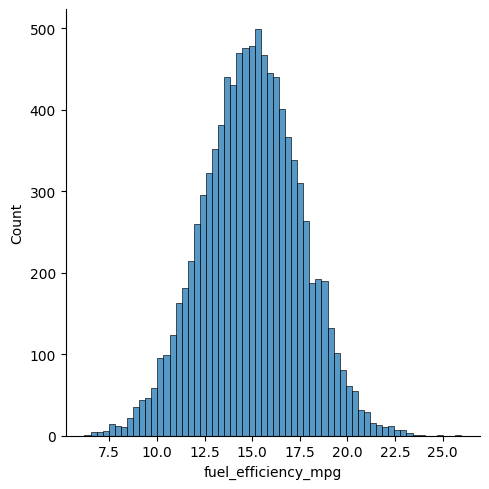

In [ ]:
sns.displot(df, x="fuel_efficiency_mpg")

We can see that `fuel_efficiency_mpg` does not have a long tail

# Question 1

In [8]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

The column with missing values is `horsepower`

# Question 2

In [ ]:
df["horsepower"].median()

np.float64(149.0)

# Question 3

In [ ]:
def val_test_train_split(
    df: pd.DataFrame,
    percentages: np.ndarray,
    random_seed: int = 42,
    target_column: str = "fuel_efficiency_mpg",
) -> tuple[
    pd.DataFrame, pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray, np.ndarray
]:
    """Perform train/validation/test spli

    Args:
        df (pd.DataFrame): The raw data
        percentages (np.ndarray): Array of fractions of total number of items to use
            for each section, so [0.1,0.2,0.7] corresponds to 10% validation,
            20% test, 70% train

        random_seed (int, optional): Random seed to use. Defaults to 42.

    Returns:
        Tuple[ pd.DataFrame, pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray, np.ndarray ]:
            The train,validation,test data frames and dependent variables
    """
    n = len(df)
    idx = np.arange(n)
    np.random.seed(random_seed)
    assert np.abs(np.sum(percentages) - 1) < 1e-10, "Percentages must add to 1"
    np.random.shuffle(idx)
    n_val = int(n * percentages[0])
    n_test = int(n * percentages[1])
    n_train = n - n_val - n_test
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train : n_train + n_val]]
    df_test = df.iloc[idx[n_train + n_val :]]
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    y_train = df_train[target_column].values
    y_val = df_val[target_column].values
    y_test = df_test[target_column].values
    # Remove the target variable from the dataframe
    df_train.drop(columns=[target_column], inplace=True)
    df_val.drop(columns=[target_column], inplace=True)
    df_test.drop(columns=[target_column], inplace=True)
    return df_train, df_val, df_test, y_train, y_val, y_test

In [ ]:
percentages = np.array([0.2, 0.2, 0.6])
df_train, df_val, df_test, y_train, y_val, y_test = val_test_train_split(
    df, percentages
)

In [ ]:
def train_linear_regression(
    X: np.ndarray, y: np.ndarray, r: float = 0.001
) -> tuple[float, np.ndarray]:
    """Perform linear regression with design matrix X and
    target variable y. Optionally can do L2 regularization.

    Args:
        X (np.ndarray): The design matrix, *without* the column of 1s
        y (np.ndarray): The target variable
        r (float, optional): Regularization parameter. Defaults to 0.001.

    Returns:
        Tuple[float, np.ndarray]: bias term, rest of weights
    """
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T @ X
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv @ X.T @ y

    return w_full[0], w_full[1:]


def prepare_X(
    df: pd.DataFrame,
    columns_to_fill: list[str] = ["horsepower"],
    fill_values: np.ndarray | None = None,
) -> np.ndarray:
    """Prepare the design matrix. Will fill any missing values

    Args:
        df (pd.DataFrame): The data frame
        columns_to_fill (List[str], optional): Columns to fill. Defaults to ["horsepower"].
        fill_values (np.ndarray | None, optional): Which value to use to replace nans.
            Should be the same shape as columns_to_fill. Defaults to None.

    Returns:
        np.ndarray: The design matrix (no 1s)
    """
    df = df.copy()
    for i, col in enumerate(columns_to_fill):
        fill_value = fill_values[i]
        df[col] = df[col].fillna(fill_value)

    X = df.values

    return X


def construct_prediction(w0: float, w_m: np.ndarray, X: np.ndarray) -> np.ndarray:
    return w0 + np.dot(X, w_m)


def rmse(y: np.ndarray, y_pred: np.ndarray) -> float:
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [18]:
X_train_mean = prepare_X(df_train, fill_values=[df_train["horsepower"].mean()])
X_train_zero = prepare_X(df_train, fill_values=[0.0])
X_val_zero = prepare_X(df_val, fill_values=[0.0])
X_val_mean = prepare_X(df_val, fill_values=[df_train["horsepower"].mean()])

In [19]:
w0_m, w_m = train_linear_regression(X_train_mean, y_train)

In [20]:
w0_z, w_z = train_linear_regression(X_train_zero, y_train)

In [ ]:
y_p_m = construct_prediction(w0_m, w_m, X_val_mean)
y_p_z = construct_prediction(w0_z, w_z, X_val_zero)

In [ ]:
print(f"RMSE for data filled with mean: {rmse(y_val, y_p_m)}")
print(f"RMSE for data filled with zero: {rmse(y_val, y_p_z)}")

RMSE for data filled with mean: 0.46355110997221366
RMSE for data filled with zero: 0.5173314578306417


# Question 4

In [25]:
rs = np.array([0, 0.01, 0.1, 1, 5, 10, 100])

In [ ]:
rmses = []
for r in rs:
    w0, w = train_linear_regression(X_train_zero, y_train, r=r)
    y_pred = construct_prediction(w0, w, X_val_zero)
    rmse_score = rmse(y_val, y_pred)
    rmses.append(np.round(rmse_score, 2))

In [42]:
rmses

[np.float64(0.52),
 np.float64(0.52),
 np.float64(0.52),
 np.float64(0.52),
 np.float64(0.52),
 np.float64(0.52),
 np.float64(0.52)]

# Question 5

In [ ]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmses = []
for seed in seeds:
    df_train, df_val, df_test, y_train, y_val, y_test = val_test_train_split(
        df, percentages, random_seed=seed
    )
    X_train = prepare_X(df_train, fill_values=np.array([0.0]))
    X_val = prepare_X(df_val, fill_values=np.array([0.0]))
    w0, w = train_linear_regression(X_train, y_train, r=0.0)
    y_p = w0 + X_val.dot(w)
    rmses.append(rmse(y_val, y_p))
rmses = np.array(rmses)

In [46]:
np.round(np.std(rmses), 3)

np.float64(0.007)

# Question 6

In [47]:
df_train, df_val, df_test, y_train, y_val, y_test = val_test_train_split(
    df, percentages, random_seed=9
)

In [52]:
df_train_combined = pd.concat((df_train, df_val))
X_train_combined = prepare_X(df_train_combined, fill_values=np.array([0.0]))
y_train_combined = np.hstack((y_train, y_val))

X_test = prepare_X(df_test, fill_values=np.array([0.0]))

In [53]:
w0, w = train_linear_regression(X_train, y_train, r=0.001)
y_p = construct_prediction(w0, w, X_test)

In [55]:
np.round(rmse(y_test, y_p), 3)

np.float64(0.516)